In [1]:
#import depdencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from keras.preprocessing import image

In [2]:
# Fixed - 2 classes as cat and dog
NUM_CLASSES = 2

# Fixed channel for colour images images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [3]:
#Model creation
model = Sequential()
#Using imagenet weights and defining shape to atch image resize
(w,h) = 224,224
model.add(ResNet50(include_top=False, weights="imagenet", input_shape=(w,h,3),pooling='avg'))
# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
# First layer is not trainable as (ResNet) model is already trained
model.layers[0].trainable = False

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [5]:
#Optimising Model

from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [6]:
#Pre-processing images to load for training and testing

from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load folders
train_generator = data_generator.flow_from_directory(
        'input/dogs-cats-images/dataset/training_set',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
        'input/dogs-cats-images/dataset/test_set',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_VALIDATION,
        class_mode='categorical') 

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:
# Print max number of steps that these generator will have opportunity to process their source content
(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))

(100, 80, 100, 20)

In [8]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'C:/Users/tgokh/Documents/Monash_Bootcamp/Github/Project-find-Lucy/model_cat_dog.h5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [9]:
#Fit model
fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/10
10/10 [==============================] - 90s 9s/step - loss: 0.5052 - accuracy: 0.7628 - val_loss: 0.0508 - val_accuracy: 0.9790
Epoch 2/10
10/10 [==============================] - 82s 9s/step - loss: 0.0390 - accuracy: 0.9855 - val_loss: 0.0545 - val_accuracy: 0.9820
Epoch 3/10
10/10 [==============================] - 82s 9s/step - loss: 0.0772 - accuracy: 0.9761 - val_loss: 0.0464 - val_accuracy: 0.9860
Epoch 4/10
10/10 [==============================] - 84s 9s/step - loss: 0.0301 - accuracy: 0.9918 - val_loss: 0.0351 - val_accuracy: 0.9860
Epoch 5/10
10/10 [==============================] - 92s 10s/step - loss: 0.0465 - accuracy: 0.9864 - val_loss: 0.0297 - val_accuracy: 0.9890
Epoch 6/10
10/10 [==============================] - 85s 9s/step - loss: 0.0437 - accuracy: 0.9901 - val_loss: 0.0371 - val_accuracy: 0.9880
Epoch 7/10
10/10 [==============================] - 88s 9s/step - loss: 0.0743 - accuracy: 0.9800 - val_loss: 0.0278 - val_accuracy: 0.9890
Epoch 8/10
10/10 [=

In [10]:
print(fit_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [11]:
#Save Model
model.save('model_cat_dog.h5') 

In [12]:
# Evaluate the model using the training data
model_loss, model_accuracy = model.evaluate(validation_generator, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

20/20 - 78s - loss: 0.0463 - accuracy: 0.9860
Loss: 0.04629428684711456, Accuracy: 0.9860000014305115


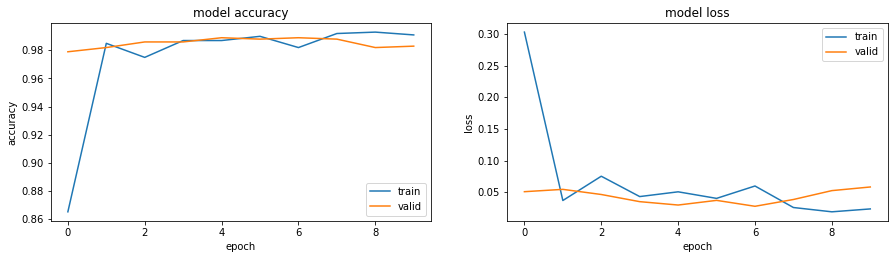

In [13]:
#Plot accuracy and loss for model
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [14]:
#Import dependencies
from keras.models import load_model
import cv2
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [15]:
#Load Model and compile it
model = load_model('model_cat_dog.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#Load image
img = cv2.imread('input/dogs-cats-images/dataset/test_set/cats/cat.4001.jpg')
img = cv2.resize(img,(224, 224))
img = np.reshape(img,[1,224, 224,3])

#Predict if it cat or dog
classes = model.predict_classes(img)

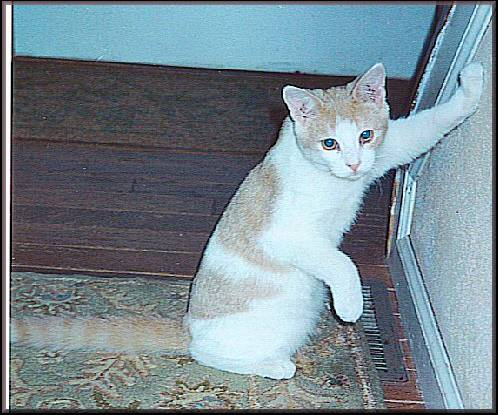

Cat


In [16]:
#Show image selected
from IPython.display import display, Image
display(Image(filename='input/dogs-cats-images/dataset/test_set/cats/cat.4001.jpg'))
if classes[0] == 0:
    print("Cat")
else:
    print("Dog")

In [17]:
#Let's try one for dog
#Load image
img = cv2.imread('input/dogs-cats-images/dataset/test_set/dogs/dog.4058.jpg')
img = cv2.resize(img,(224, 224))
img = np.reshape(img,[1,224, 224,3])

#Predict if it cat or dog
classes = model.predict_classes(img)

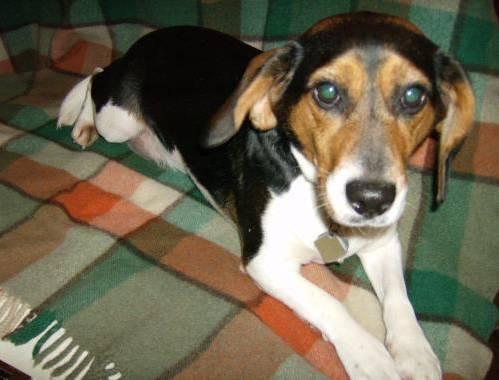

Dog


In [18]:
#Show image selected
from IPython.display import display, Image
display(Image(filename='input/dogs-cats-images/dataset/test_set/dogs/dog.4058.jpg'))
if classes[0] == 0:
    print("Cat")
else:
    print("Dog")